In [1]:
# Import basic modules
import numpy as np
import pandas as pd
pd.options.display.max_columns = 1000
import matplotlib.pyplot as plt
import seaborn as sns
import os
import category_encoders as ce

# Import learning modules
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn import linear_model, preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from catboost import CatBoostClassifier, cv, Pool

In [2]:
# For EDA - scatter plots of each independent variable to dependent variable
def scatterplots(columns, y_col, data, ncol=None, figsize=(15,8)) :
    if ncol == None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = y_col, data = data, alpha=0.2)
        ax.set(xlabel=col, ylabel=y_col)
    nsubplots = nrow * ncol
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
        
# For plotting your predictions versus true
def pred_plot(title, y_true, y_pred, figsize=(8,6)):
    sns.set()
    fig, ax = plt.subplots(figsize=(8,6))
    
    ax.scatter(y_true, y_pred, color='b', alpha=0.4, label='predicted')
    ax.plot(y_true, y_true, marker='.', linestyle='-', color='r', label='perfect "model"')

    ax.set_xlabel('true')
    ax.set_ylabel('predicted')
    ax.set_title(title, fontsize=15)
    ax.legend()

    plt.show()
    
# For displaying CV result statistics
def test_stat(model, y_true, y_pred):
    print(model, ": ")
    print("R^2: ", round(r2_score(y_true, y_pred), 4))
    print("RMSE: ", round((mean_squared_error(y_true, y_pred)) ** 0.5, 4))
    print("MAE: ", round(mean_absolute_error(y_true, y_pred), 4))
    
# For plotting residuals
def res_plot(model_name, X, y_true, y_pred, ncol=None, figsize=(15,8)):
    y_res = y_pred - y_true
    if ncol == None:
        ncol = len(X.columns)
    nrow = int(np.ceil(len(X.columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, c in enumerate(X.columns):
        ax = axes.flatten()[i]
        ax.scatter(X[c], y_res, alpha=0.2)
        ax.axhline(0, c='r', linestyle='--')
        ax.set(xlabel=c, ylabel='y residual')
    nsubplots = nrow * ncol
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
    fig.suptitle(model_name, y=0)
    fig.tight_layout()
    plt.show()

In [3]:
# Read file
df = pd.read_csv('Data/Written_essay_scores_cleaned.csv')

In [4]:
df['Grade'] = df['Grade'].fillna(0)

cols = ['Major', 'Field']
for c in cols:
    df[c] = df[c].fillna('Other')

df = df.drop(['Unnamed: 0'], axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Total 1 (%)    321 non-null    float64
 1   Country        321 non-null    object 
 2   PTJ1           321 non-null    int64  
 3   SMK1           321 non-null    int64  
 4   Sex            321 non-null    object 
 5   Age            321 non-null    int64  
 6   Grade          321 non-null    float64
 7   Major          321 non-null    object 
 8   Field          321 non-null    object 
 9   VST            321 non-null    float64
 10  CEFR           321 non-null    object 
 11  INTM           321 non-null    float64
 12  INSM           321 non-null    float64
 13  Primary        321 non-null    float64
 14  Secondary      321 non-null    float64
 15  College        321 non-null    float64
 16  Inschool       321 non-null    float64
 17  Outschool      321 non-null    float64
 18  Listening 

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Total 1 (%),321.0,67.590810,13.404711,11.65,59.20,67.50,76.65,99.15
PTJ1,321.0,233.844237,31.212588,180.00,212.00,224.00,249.00,334.00
SMK1,321.0,227.704050,30.151642,181.00,206.00,218.00,243.00,331.00
Age,321.0,20.000000,2.007797,16.00,19.00,20.00,21.00,29.00
Grade,321.0,2.006231,1.232360,0.00,1.00,2.00,3.00,7.00
VST,321.0,34.922118,8.246411,11.00,30.00,35.00,41.00,48.00
INTM,321.0,4.576916,0.894875,0.00,4.17,4.67,5.17,6.00
INSM,321.0,4.583551,0.955153,0.00,4.17,4.67,5.33,6.00
Primary,321.0,2.987539,1.449084,1.00,2.00,3.00,4.00,6.00
Secondary,321.0,3.646106,1.052957,1.00,3.00,3.63,4.25,6.00


In [7]:
X = df.drop(['Total 1 (%)'], axis=1).copy()
y = df['Total 1 (%)'].copy()

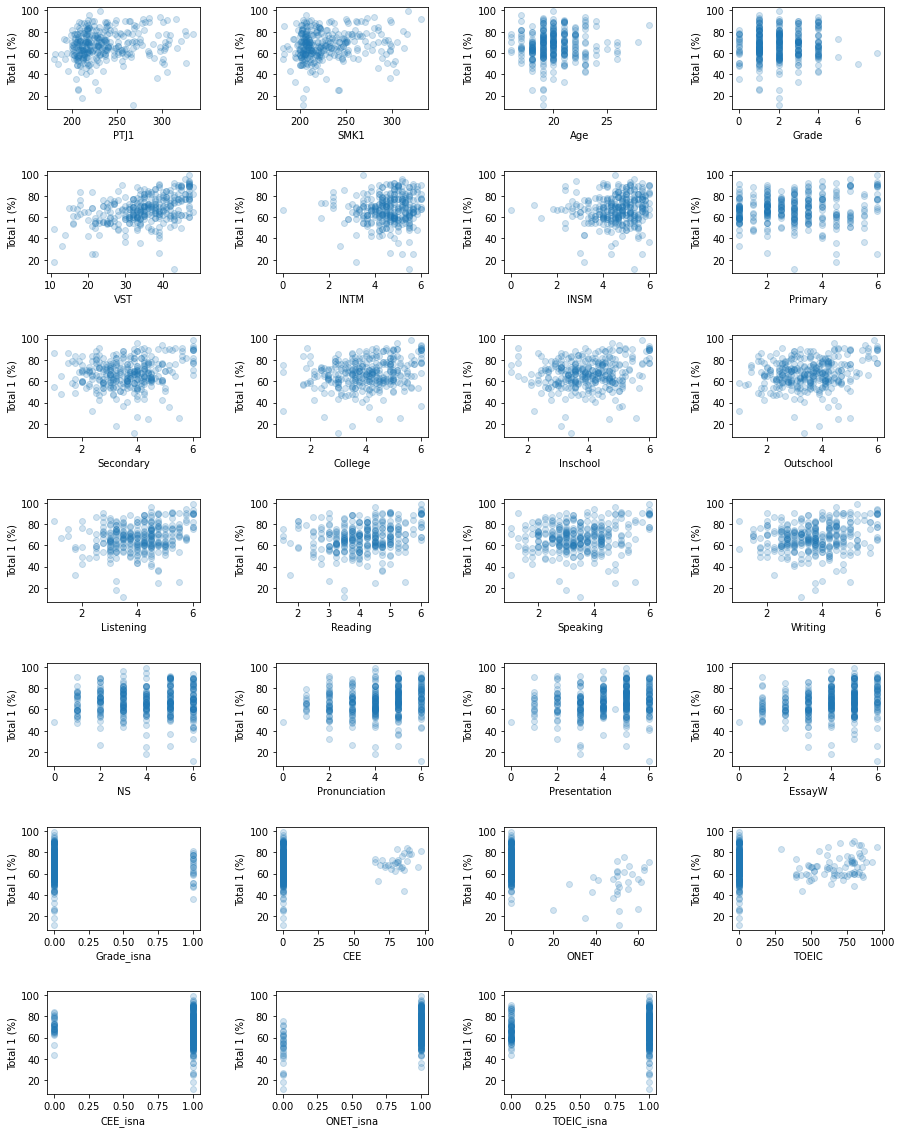

In [8]:
# Quick EDA for feature analysis.
scatterplots(columns = X.select_dtypes(include=np.number).columns, y_col = 'Total 1 (%)', data=df, ncol=4, figsize=(15, 20))

In [9]:
ce_hash = ce.HashingEncoder(cols=['Major'])
X = ce_hash.fit_transform(X)

C:\Users\jaeyo\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [10]:
# Get dummies
X = pd.get_dummies(X, dtype='int64')
X.shape

(321, 56)

In [11]:
X.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,PTJ1,SMK1,Age,Grade,VST,INTM,INSM,Primary,Secondary,College,Inschool,Outschool,Listening,Reading,Speaking,Writing,NS,Pronunciation,Presentation,EssayW,Grade_isna,CEE,ONET,TOEIC,CEE_isna,ONET_isna,TOEIC_isna,Country_CHN,Country_HKG,Country_IDN,Country_JPN,Country_KOR,Country_PAK,Country_PHL,Country_SIN,Country_THA,Country_TWN,Sex_F,Sex_M,Field_Humanities,Field_Life Sciences,Field_Other,Field_Sciences & Technology,Field_Social Sciences,CEFR_A2_0,CEFR_B1_1,CEFR_B1_2,CEFR_B2_0
0,0,1,0,0,0,0,0,0,271,219,20,2.0,30.0,0.00,0.00,2.0,3.63,4.25,3.89,3.56,4.00,4.50,3.50,3.75,4.0,5.0,5.0,4.0,0,72.0,0.0,0.0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
1,0,1,0,0,0,0,0,0,203,292,21,3.0,27.0,4.17,4.33,2.5,4.00,1.86,3.00,2.88,3.00,3.00,2.75,3.33,3.0,3.0,3.0,3.0,0,77.0,0.0,0.0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
2,0,1,0,0,0,0,0,0,238,250,20,3.0,32.0,5.17,5.17,3.5,4.25,4.25,4.22,4.11,5.00,4.00,3.75,4.25,4.0,5.0,5.0,5.0,0,79.0,0.0,0.0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
3,0,0,0,0,0,1,0,0,269,230,20,2.0,37.0,4.67,5.17,1.0,2.75,4.25,3.44,3.00,3.75,3.75,3.25,3.25,3.0,5.0,5.0,5.0,0,87.0,0.0,0.0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,1,0,0,225,208,20,2.0,44.0,5.17,5.33,2.0,3.63,4.88,4.33,3.67,5.00,5.00,3.25,3.75,3.0,5.0,5.0,5.0,0,84.0,0.0,0.0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0


In [12]:
# Train Test split. Check their shapes and types
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(type(X_train), type(X_test), type(y_train), type(y_test))

(240, 56) (81, 56) (240,) (81,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [13]:
X_train = X_train.copy()
X_test = X_test.copy()

In [14]:
ptransform = PowerTransformer()

for col in ['PTJ1', 'SMK1']:
    ptransform.fit(X_train[[col]])
    X_train[col] = ptransform.transform(X_train[[col]])
    X_test[col] = ptransform.transform(X_test[[col]])

In [15]:
scaler = MinMaxScaler()

for col in ['CEE', 'ONET', 'TOEIC']:
    scaler.fit(X_train[[col]])
    X_train[col] = scaler.transform(X_train[[col]])
    X_test[col] = scaler.transform(X_test[[col]])

In [20]:
def rf_eval(n_estimators, max_depth, max_features):
    rf = RandomForestRegressor(
        n_estimators = int(n_estimators),
        max_depth =  int(max_depth),
        max_features = int(max_features),
        n_jobs = -1, 
        random_state = 42
    )
    cv_score = cross_val_score(rf, X_train, y_train, cv=10, n_jobs=-1).mean()
    return cv_score

In [21]:
rfBO = BayesianOptimization(rf_eval, {
    'n_estimators': (10, 10000),
    'max_depth': (5, 100),
    'max_features': (3, len(X_train.columns))
})

rfBO.maximize(n_iter=30, init_points=2)

|   iter    |  target   | max_depth | max_fe... | n_esti... |
-------------------------------------------------------------
|  1        |  0.348    |  90.88    |  42.43    |  1.362e+0 |
|  2        |  0.3524   |  30.77    |  26.65    |  2.502e+0 |
|  3        |  0.3503   |  26.22    |  37.93    |  2.511e+0 |
|  4        |  0.35     |  39.05    |  27.52    |  2.499e+0 |
|  5        |  0.3563   |  8.625    |  29.06    |  9.955e+0 |
|  6        |  0.3476   |  21.6     |  33.3     |  6.736e+0 |
|  7        |  0.3523   |  30.81    |  26.64    |  2.503e+0 |
|  8        |  0.352    |  18.59    |  23.68    |  9.962e+0 |
|  9        |  0.3564   |  6.795    |  36.41    |  9.944e+0 |
|  10       |  0.3492   |  5.317    |  17.87    |  9.945e+0 |
|  11       |  0.3485   |  14.74    |  39.53    |  9.952e+0 |
|  12       |  0.3525   |  11.72    |  33.97    |  9.933e+0 |
|  13       |  0.3553   |  9.698    |  32.1     |  9.941e+0 |
|  14       |  0.3499   |  23.35    |  19.9     |  2.49e+03 |
|  15   

In [22]:
rfBO.max

{'target': 0.35766772703341126,
 'params': {'max_depth': 7.136446030279686,
  'max_features': 31.65186751561471,
  'n_estimators': 9951.557153888496}}

In [23]:
rf_best = RandomForestRegressor(
    n_estimators = 9951,
    max_depth = 7,
    max_features = 31,
    n_jobs = -1,
    random_state = 42
)
rf_best.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, max_features=31, n_estimators=9951,
                      n_jobs=-1, random_state=42)

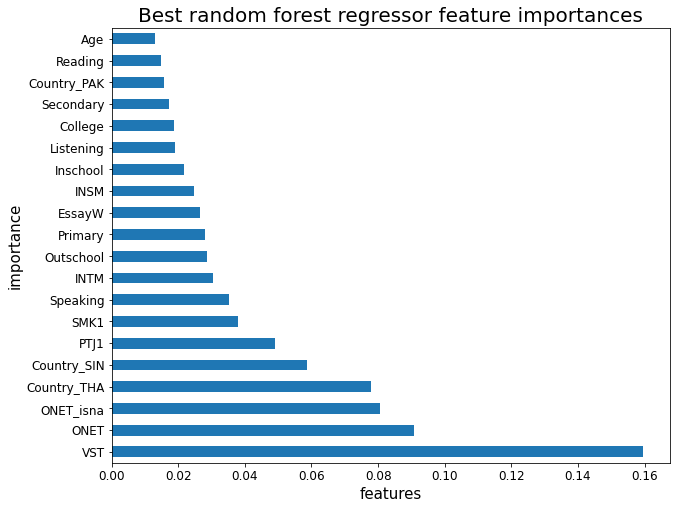

In [24]:
# Plot the top 20 feature importances.
plt.subplots(figsize=(10, 8))
imps = rf_best.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)[:20]
_ = rf_feat_imps.plot(kind='barh', fontsize=12)
_ = plt.xlabel('features', fontsize=15)
_ = plt.ylabel('importance', fontsize=15)
_ = plt.title('Best random forest regressor feature importances', fontsize=20);
plt.show()

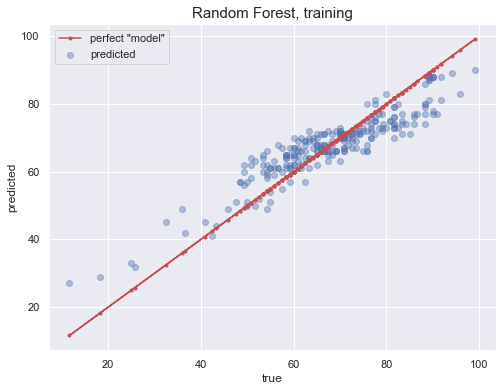

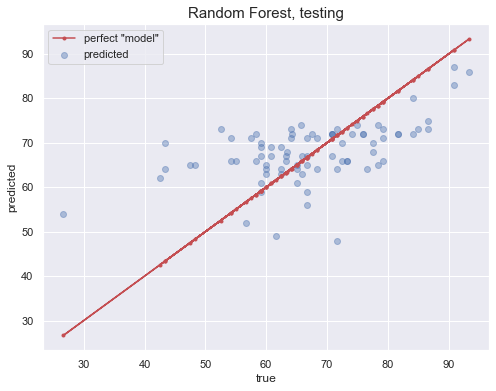

In [25]:
# Predict on Training and Test sets using Light GBM model
y_tr_rf_pred = rf_best.predict(X_train)
y_te_rf_pred = rf_best.predict(X_test)

# Plot predicted vs true
pred_plot("Random Forest, training", y_train, np.round(y_tr_rf_pred))
pred_plot("Random Forest, testing", y_test, np.round(y_te_rf_pred))

In [26]:
# Print test stats
test_stat("Random Forest", y_test, y_te_rf_pred)

Random Forest : 
R^2:  0.2936
RMSE:  9.9286
MAE:  7.8326


In [27]:
xgb.set_config(verbosity=0)

def xg_eval(n_estimators, max_depth, min_child_weight, learning_rate, gamma):
    xg = XGBRegressor(
        objective = 'reg:linear',
        n_estimators = int(n_estimators),
        max_depth =  int(max_depth),
        min_child_weight = int(min_child_weight),
        learning_rate = 10 ** learning_rate,
        gamma = 10 ** gamma,
        num_boost_round = 1000,
        early_stopping_rounds = 100,
        seed = 42
    )
    cv_score = cross_val_score(xg, X_train, y_train, cv=10, n_jobs=-1).mean()
    return cv_score

In [28]:
xgBO = BayesianOptimization(xg_eval, {
    'n_estimators': (10, 1000),
    'max_depth': (1, 50),
    'min_child_weight': (1, 10),
    'learning_rate': (-3, 0),
    'gamma': (-3, 1)
})

xgBO.maximize(n_iter=30, init_points=2)

|   iter    |  target   |   gamma   | learni... | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------------------
|  1        | -0.2143   |  0.4201   | -2.677    |  9.64     |  7.693    |  935.5    |
|  2        | -7.798    | -0.3422   | -2.396    |  29.36    |  5.525    |  153.6    |
|  3        | -0.4158   | -0.6726   | -2.713    |  11.08    |  7.404    |  936.3    |
|  4        | -0.01438  |  1.0      |  0.0      |  1.0      |  10.0     |  875.4    |
|  5        | -5.664    |  1.0      | -3.0      |  1.0      |  10.0     |  771.6    |
|  6        | -0.2537   |  1.0      |  0.0      |  50.0     |  10.0     |  468.1    |
|  7        | -0.1011   | -3.0      |  0.0      |  1.0      |  10.0     |  411.8    |
|  8        | -13.32    |  1.0      | -3.0      |  50.0     |  1.0      |  359.6    |
|  9        | -10.61    | -3.0      | -3.0      |  1.0      |  1.0      |  466.3    |
|  10       | -0.2537   |  1.0      |  0.0      |  18.

In [30]:
xgBO.max

{'target': 0.36613008544047276,
 'params': {'gamma': -0.22989066246738732,
  'learning_rate': -0.5027281722192476,
  'max_depth': 3.1863398057699674,
  'min_child_weight': 5.0669446241114855,
  'n_estimators': 10.016158985329845}}

In [31]:
xg_best = XGBRegressor(
    objective = 'reg:linear',
    n_estimators = 10,
    max_depth = 3,
    min_child_weight = 5,
    learning_rate = 10 ** -0.5027281722192476,
    gamma = 10 ** -0.22989066246738732,
    num_boost_round = 1000,
    seed = 42
)
xg_best.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.5889919206921227,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.31424749742716934, max_delta_step=0, max_depth=3,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=8, num_boost_round=1000,
             num_parallel_tree=1, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

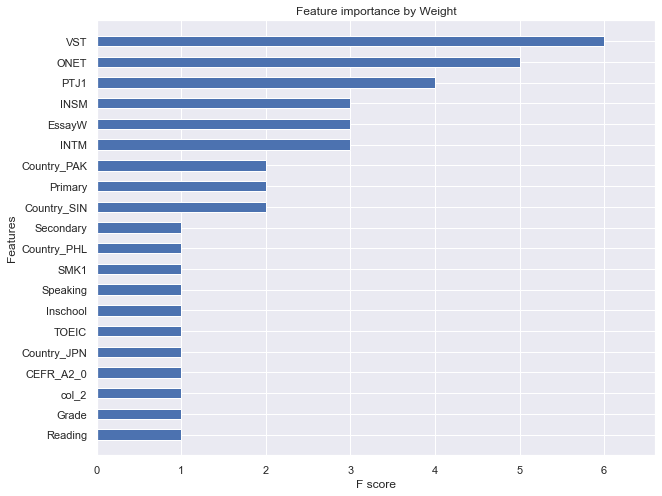

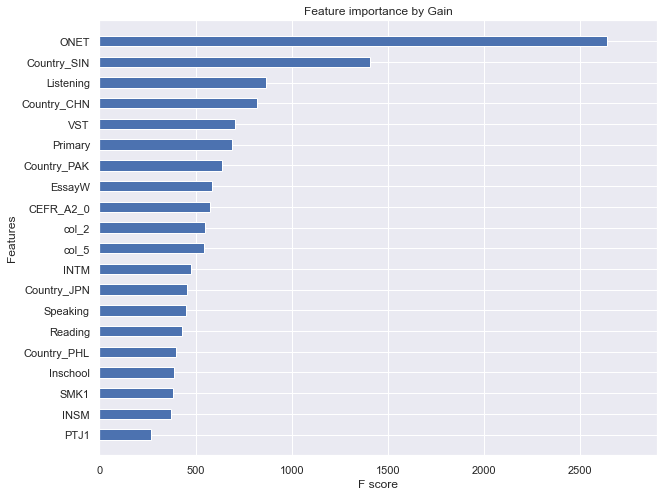

In [32]:
# Plot top 20 feature importances of XG Boost model. Importance type 'weight' and 'gain' show completely different results. Plot both
fig, ax = plt.subplots(figsize=(10,8))
xgb.plot_importance(xg_best, importance_type = 'weight', ax=ax, title='Feature importance by Weight', 
                    height=0.5, max_num_features=20, show_values=False)
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
xgb.plot_importance(xg_best, importance_type = 'gain', ax=ax, title='Feature importance by Gain', 
                    height=0.5, max_num_features=20, show_values=False)
plt.show()

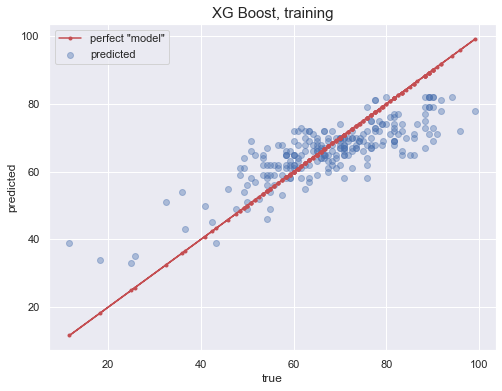

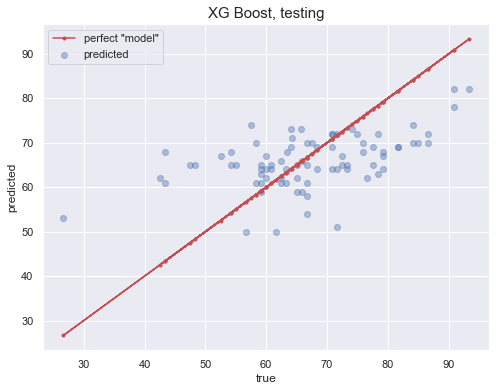

In [33]:
# Predict on Training and Test sets using Light GBM model
y_tr_xg_pred = xg_best.predict(X_train)
y_te_xg_pred = xg_best.predict(X_test)

# Plot predicted vs true
pred_plot("XG Boost, training", y_train, np.round(y_tr_xg_pred))
pred_plot("XG Boost, testing", y_test, np.round(y_te_xg_pred))

In [34]:
# Print test stats
test_stat("XG Boost", y_test, y_te_xg_pred)

XG Boost : 
R^2:  0.2548
RMSE:  10.1979
MAE:  8.2147


In [35]:
# Initialize pipeline for optional StandardScaler followed by Lasso regression
scaler = StandardScaler()
lasso = Lasso(random_state=42)
pipe = make_pipeline(scaler, lasso)

# Parameter grid for pipeline - scaler is optional.
params = {
    'standardscaler': [StandardScaler(), None],
    'lasso__alpha': [n for n in np.logspace(-6,0,13)],
    'lasso__max_iter': [1000, 10000]
}

# 3-fold CV Grid Search, fit, and print CV test results for top five estimators. Commented out for run-through
lasso_grid_cv = GridSearchCV(pipe, params, cv=10, n_jobs=-1)
lasso_grid_cv.fit(X_train, y_train)
print(lasso_grid_cv.best_params_)
pd.DataFrame(lasso_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

{'lasso__alpha': 1.0, 'lasso__max_iter': 1000, 'standardscaler': StandardScaler()}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso__alpha,param_lasso__max_iter,param_standardscaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
48,0.008080,0.000536,0.003191,0.001163,1.0,1000,StandardScaler(),"{'lasso__alpha': 1.0, 'lasso__max_iter': 1000,...",0.100502,0.254175,0.405351,0.312160,0.502519,0.594686,0.556857,0.346881,0.392454,0.323350,0.378894,0.140009,1
50,0.007580,0.000914,0.002892,0.000299,1.0,10000,StandardScaler(),"{'lasso__alpha': 1.0, 'lasso__max_iter': 10000...",0.100502,0.254175,0.405351,0.312160,0.502519,0.594686,0.556857,0.346881,0.392454,0.323350,0.378894,0.140009,1
46,0.007880,0.001040,0.003590,0.001902,0.316228,10000,StandardScaler(),"{'lasso__alpha': 0.31622776601683794, 'lasso__...",0.119657,0.312983,0.405897,0.247380,0.509484,0.669332,0.598436,0.186448,0.306121,0.242392,0.359813,0.172193,3
44,0.008577,0.001353,0.003392,0.001558,0.316228,1000,StandardScaler(),"{'lasso__alpha': 0.31622776601683794, 'lasso__...",0.119657,0.312983,0.405897,0.247380,0.509484,0.669332,0.598436,0.186448,0.306121,0.242392,0.359813,0.172193,3
47,0.004588,0.000489,0.002992,0.000446,0.316228,10000,None,"{'lasso__alpha': 0.31622776601683794, 'lasso__...",0.015769,0.194776,0.404831,0.408379,0.519243,0.578823,0.526849,0.201805,0.387438,0.204415,0.344233,0.172836,5


In [36]:
scaler = StandardScaler()
lasso_best = Lasso(alpha=1.0, max_iter=1000)
pipe_best = make_pipeline(scaler, lasso_best)
pipe_best.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('lasso', Lasso())])

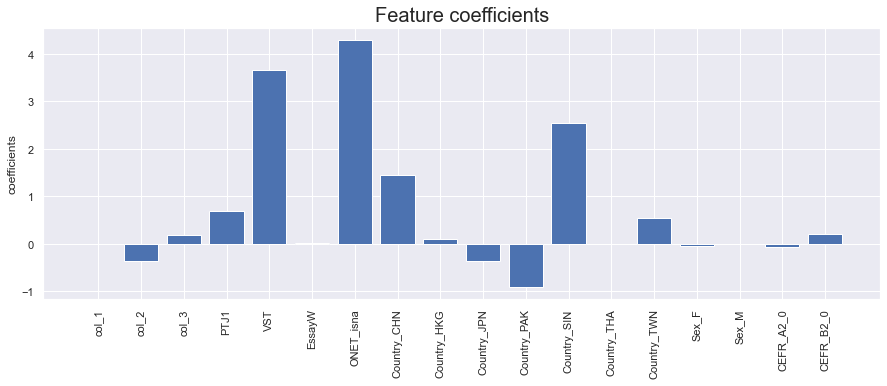

In [38]:
# For plotting purposes - keep only the coefficients of absolute value > 0.2 to keep the plot visually comprehensible
lasso_coefs = pd.DataFrame(lasso_best.coef_, index=X_train.columns, columns=['coef'])
lasso_coefs = lasso_coefs[abs(lasso_coefs.coef) > 0]

# Plot feature coefficients of Lasso regression
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(lasso_coefs.index, lasso_coefs.coef)
plt.xticks(rotation='vertical')
plt.ylabel('coefficients')
plt.title('Feature coefficients', fontsize=20)
plt.show()

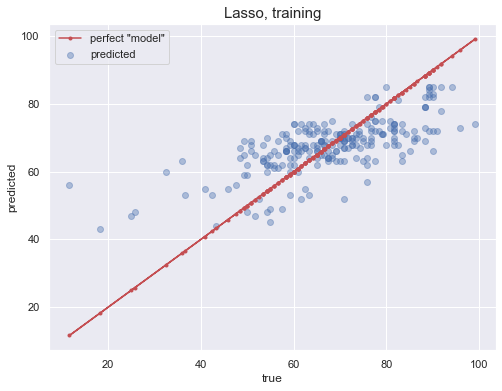

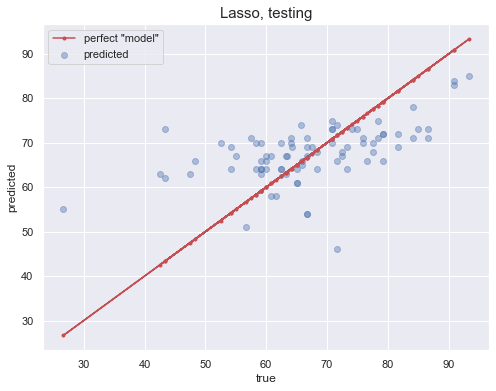

In [39]:
# Predict Testing and Test sets using Lasso regression
y_tr_lasso_pred = pipe_best.predict(X_train)
y_te_lasso_pred = pipe_best.predict(X_test)

# Plot predicted vs true
pred_plot("Lasso, training", y_train, np.round(y_tr_lasso_pred))
pred_plot("Lasso, testing", y_test, np.round(y_te_lasso_pred))

In [40]:
# Print test stats for Lasso
test_stat("Lasso", y_test, y_te_lasso_pred)

Lasso : 
R^2:  0.2996
RMSE:  9.8866
MAE:  7.7317


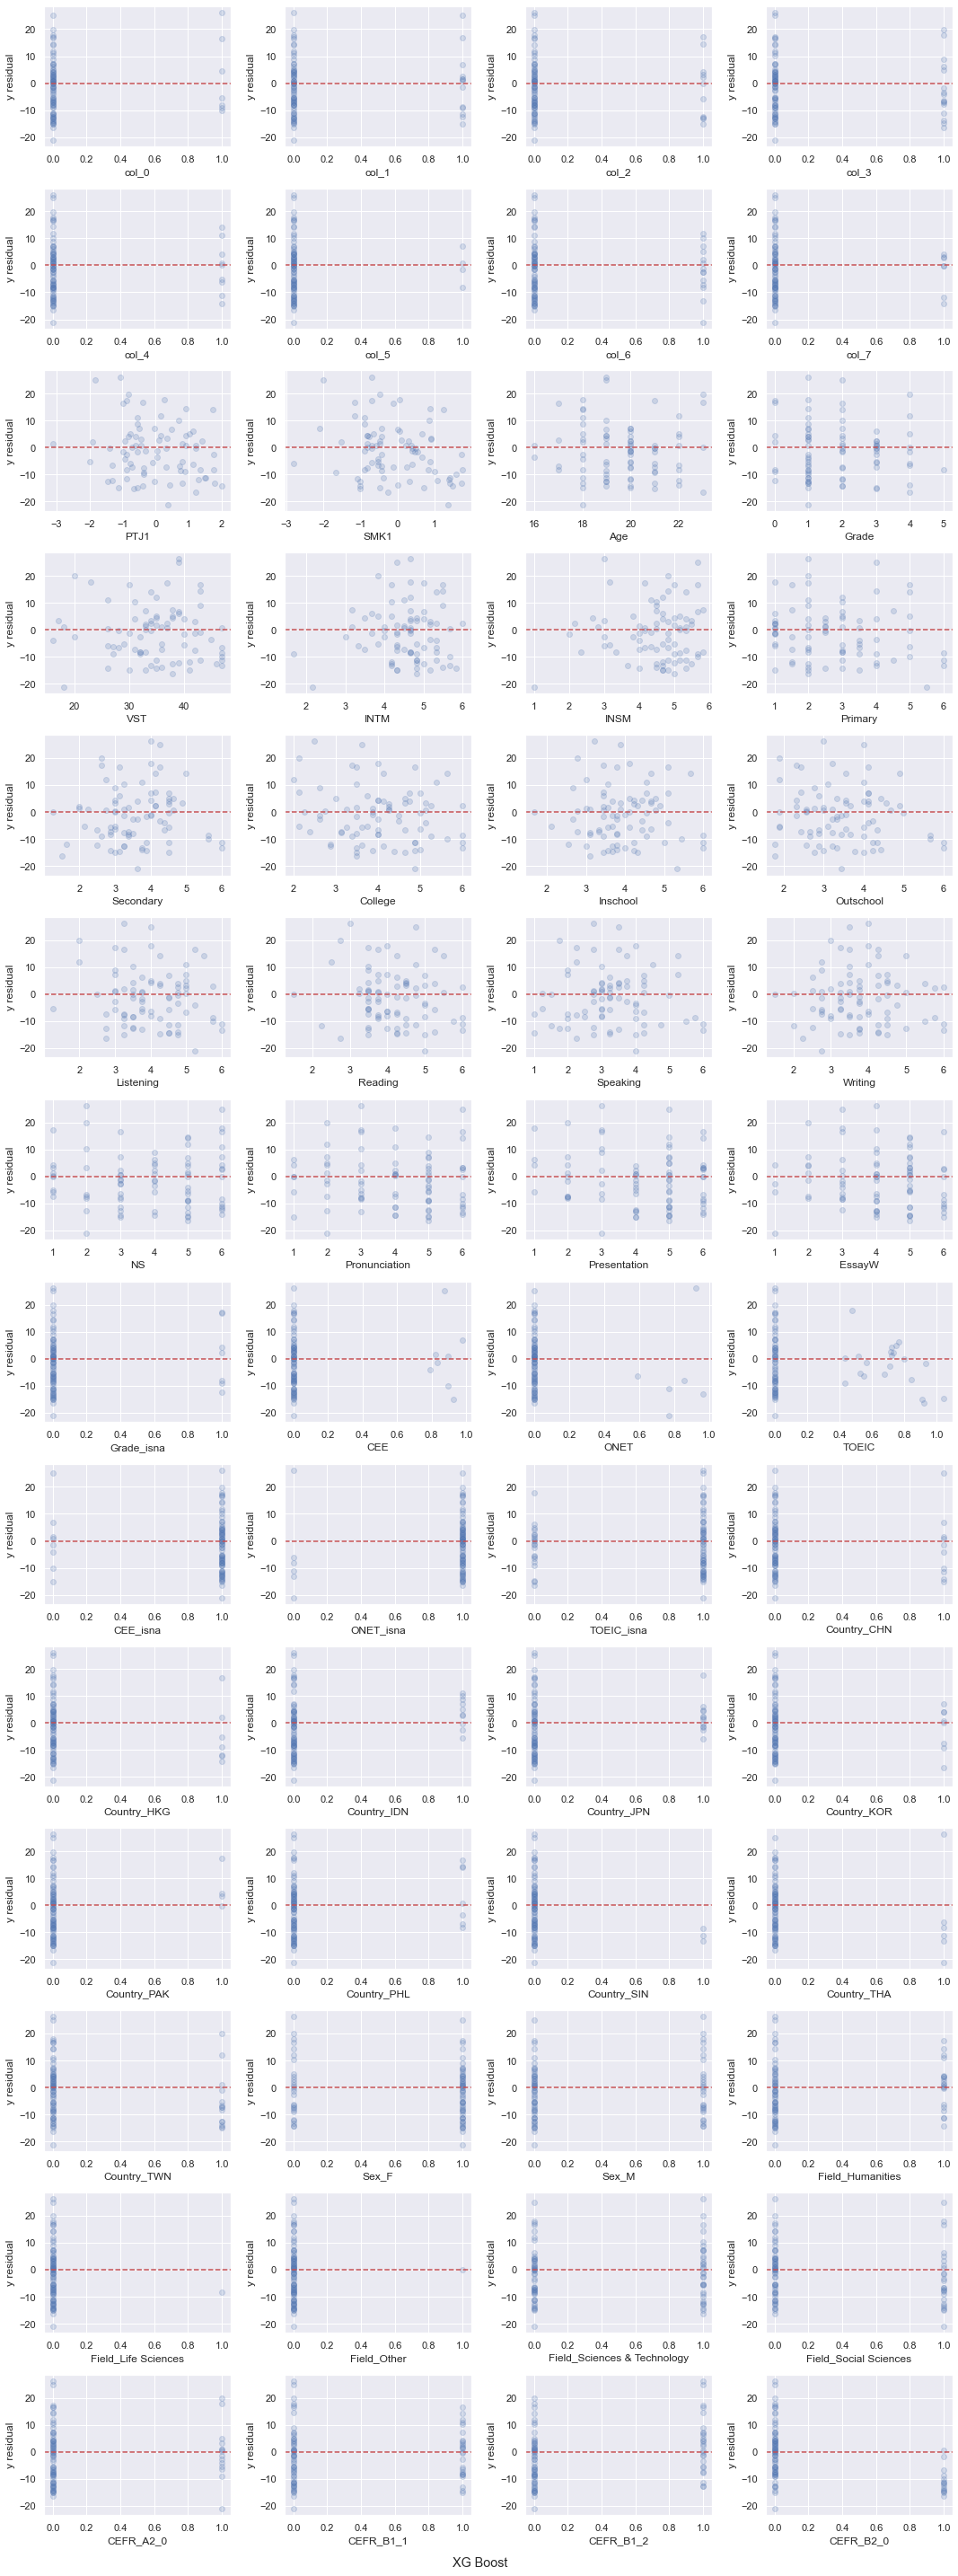

In [41]:
# XG Boost Testing prediction residuals
res_plot('XG Boost', X_test, y_test, y_te_xg_pred, ncol=4, figsize=(15,40))

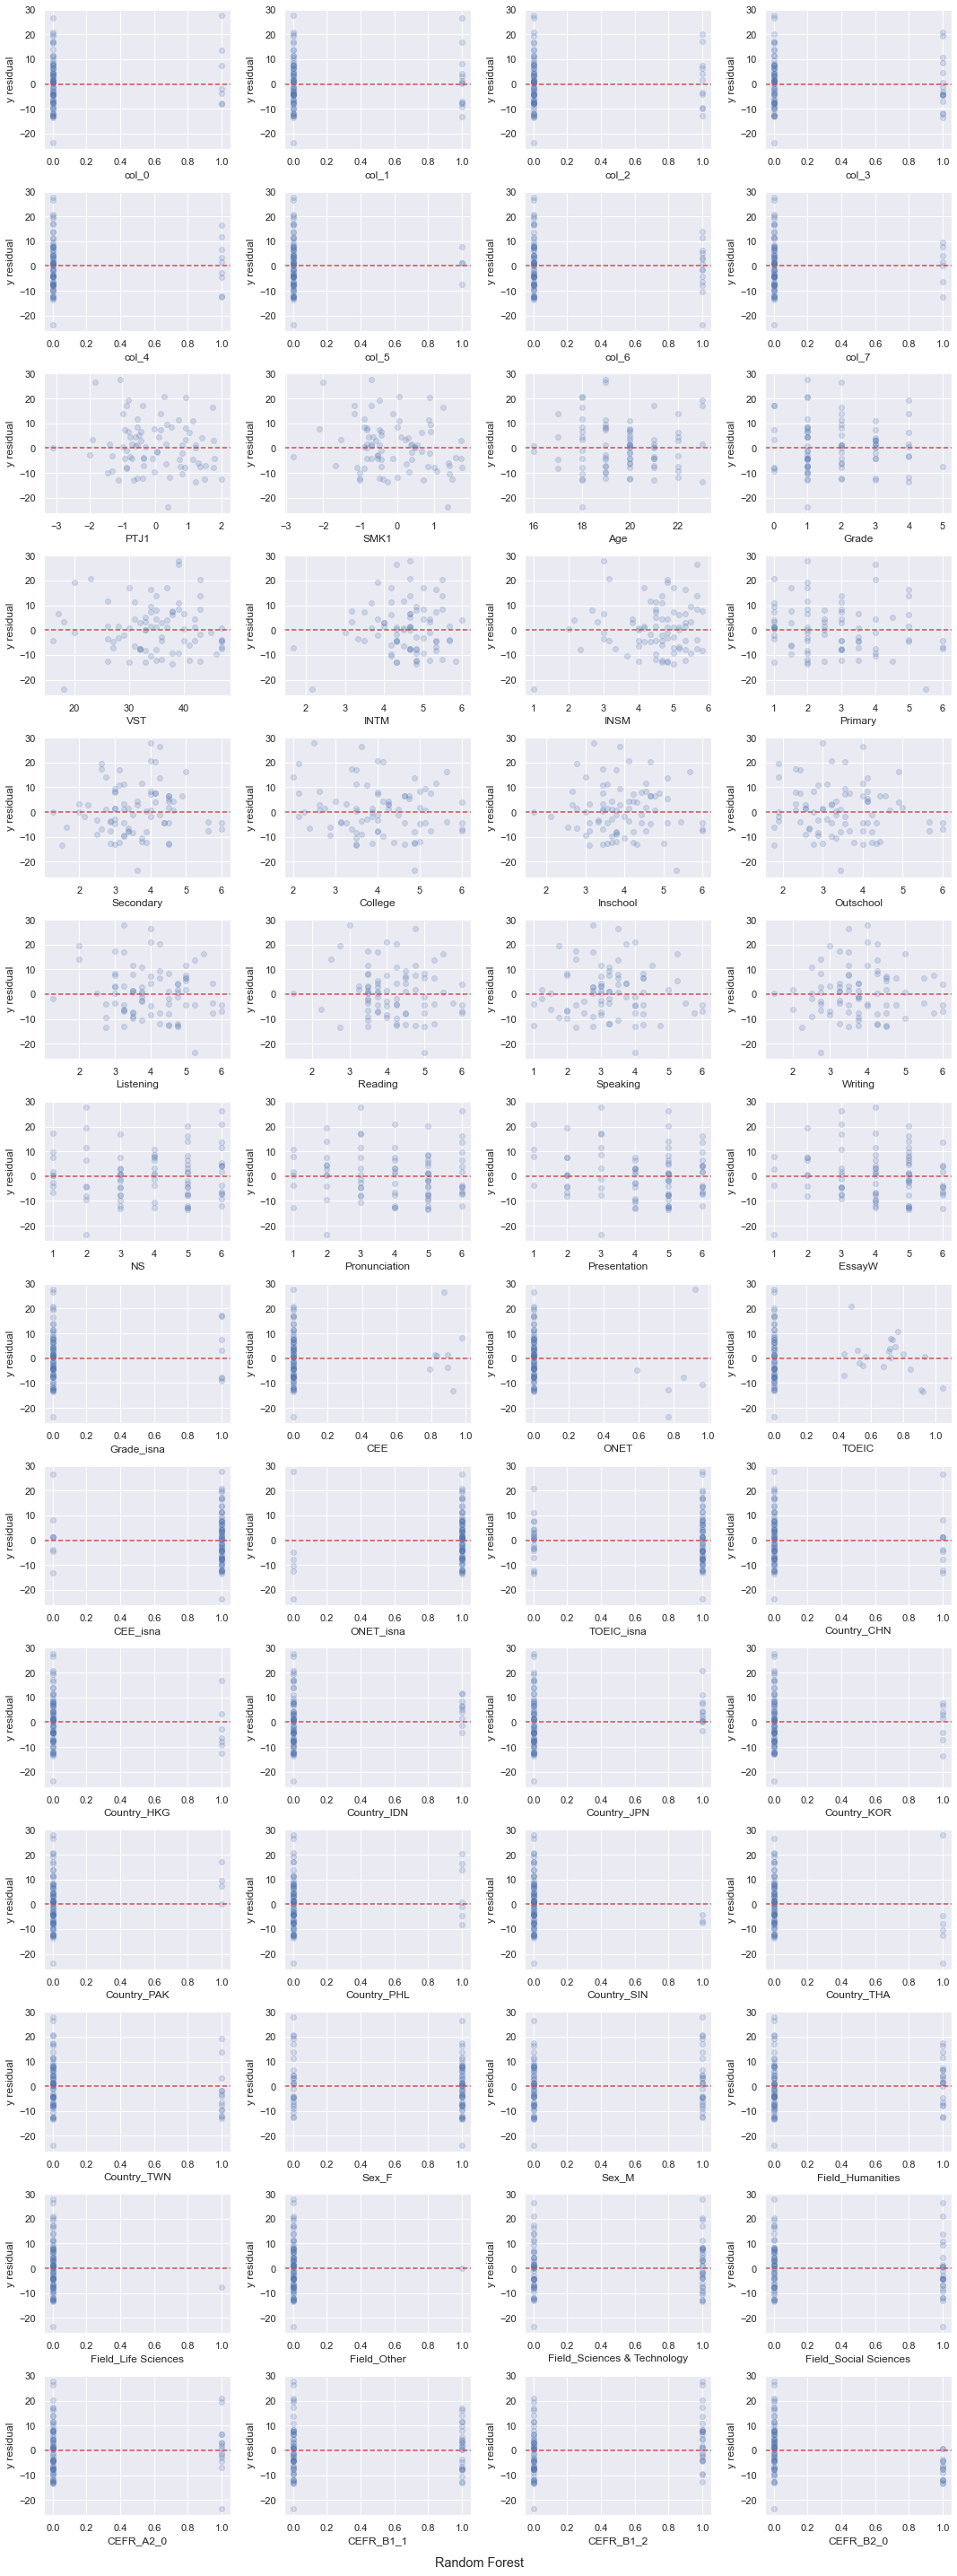

In [42]:
# XG Boost Testing prediction residuals
res_plot('Random Forest', X_test, y_test, y_te_rf_pred, ncol=4, figsize=(15,40))

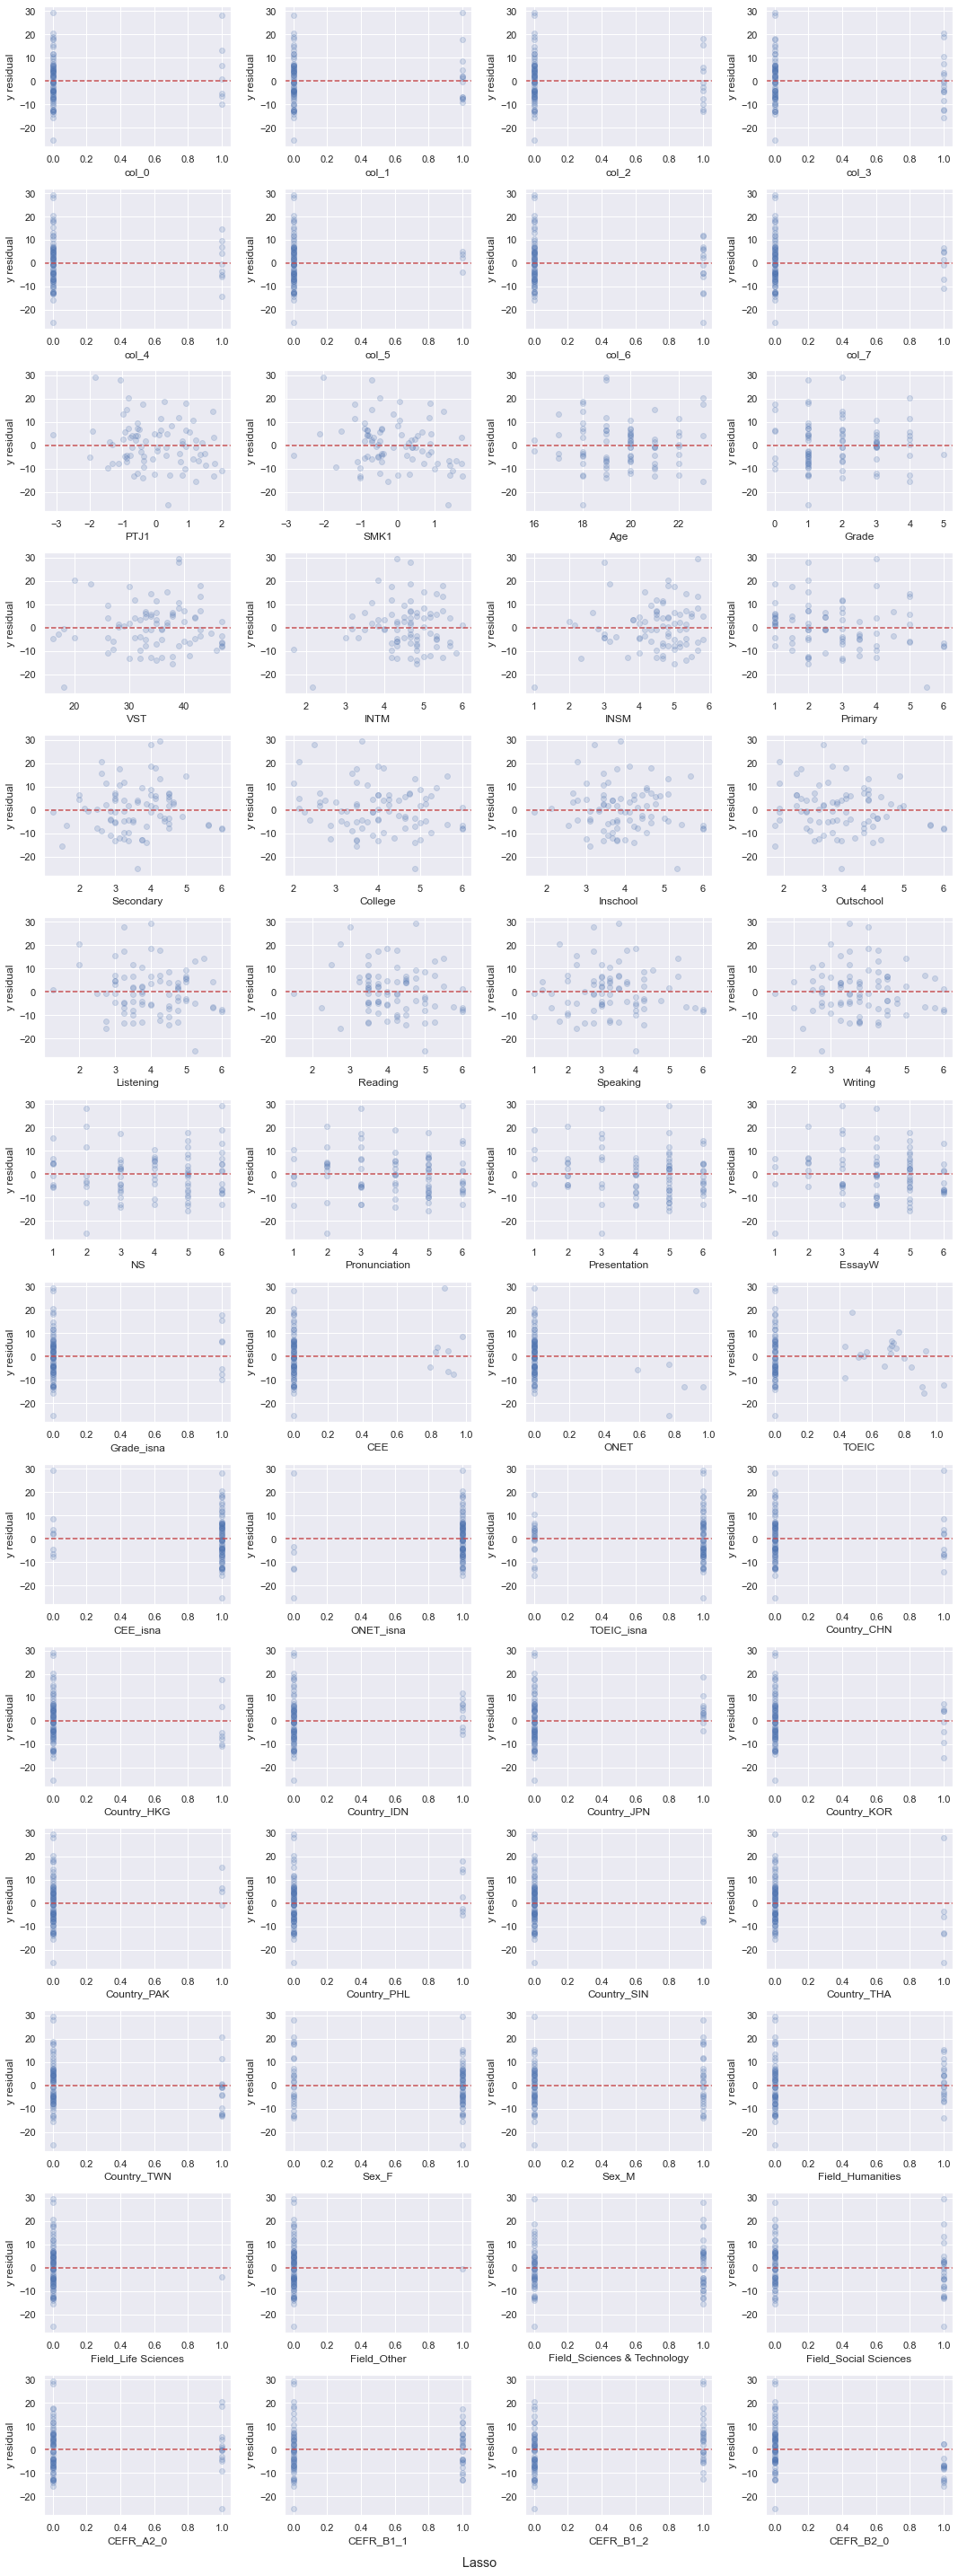

In [43]:
# XG Boost Testing prediction residuals
res_plot('Lasso', X_test, y_test, y_te_lasso_pred, ncol=4, figsize=(15,40))